In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.animation as animation
import os

from collections import OrderedDict

In [2]:
# define parameters
hidden_layers = 5
nodes_per_layer = 100

# define output directory
sim_type = 'lid_cavity'
out_dir = os.path.join('results', '%dnode%dlayer' % (nodes_per_layer, hidden_layers), sim_type)

if not os.path.isdir(out_dir):
    os.makedirs(out_dir)


In [3]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.layers = [3] + [nodes_per_layer for _ in range(hidden_layers)] + [2]
        self.depth = len(self.layers) - 1

        self.activation = nn.Tanh

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(('layer_%d' % i, torch.nn.Linear(self.layers[i], self.layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(('layer_%d' % (self.depth - 1), nn.Linear(self.layers[-2], self.layers[-1])))

        layerDict = OrderedDict(layer_list)
        self.model = nn.Sequential(layerDict)
        self.model.apply(self.init_weights)

    # Xavier initilization
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        out = self.model(x)
        return out

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nu = 0.01/np.pi

class NS:
    def __init__(self, X, Y, T, u, v):
        self.x = torch.tensor(X, dtype=torch.float32, requires_grad=True).to(device)
        self.y = torch.tensor(Y, dtype=torch.float32, requires_grad=True).to(device)
        self.t = torch.tensor(T, dtype=torch.float32, requires_grad=True).to(device)

        self.u = torch.tensor(u, dtype=torch.float32).to(device)
        self.v = torch.tensor(v, dtype=torch.float32).to(device)

        self.null = torch.zeros((self.x.shape[0], 1)).to(device)
        
        self.net = DNN().to(device)

        # track loss history
        self.loss_history = []
        self.loss_history_u = []
        self.loss_history_v = []
        self.loss_history_f = []
        self.loss_history_g = []

        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.01)

        # self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr=1, max_iter=200000, max_eval=50000, 
        #                                    history_size=50, tolerance_grad=1e-5, tolerance_change=0.5 * np.finfo(float).eps, line_search_fn="strong_wolfe")
        
        self.mse = nn.MSELoss().to(device)

        self.ls = 0
        self.iter = 0

    def function(self, x, y, t):
        res = self.net(torch.hstack((x, y, t)))
        psi, p = res[:, 0:1], res[:, 1:2]

        u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), 
                                create_graph=True)[0]
        v = -1.*torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), 
                                    create_graph=True)[0]

        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), 
                                  create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), 
                                   create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), 
                                  create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), 
                                   create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), 
                                  create_graph=True)[0]

        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), 
                                  create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), 
                                   create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), 
                                  create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), 
                                   create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), 
                                  create_graph=True)[0]

        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), 
                                  create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), 
                                  create_graph=True)[0]

        f = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
        g = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)

        return u, v, p, f, g
    
    def closure(self):
        self.optimizer.zero_grad()

        u_pred, v_pred, p_pred, f_pred, g_pred = self.function(self.x, self.y, self.t)

        u_loss = self.mse(u_pred, self.u)
        v_loss = self.mse(v_pred, self.v)
        f_loss = self.mse(f_pred, self.null)
        g_loss = self.mse(g_pred, self.null)

        self.ls = u_loss + v_loss + f_loss + g_loss

        self.loss_history.append(self.ls.detach().cpu().numpy())
        self.loss_history_u.append(u_loss.detach().cpu().numpy())
        self.loss_history_v.append(v_loss.detach().cpu().numpy())
        self.loss_history_f.append(f_loss.detach().cpu().numpy())
        self.loss_history_g.append(g_loss.detach().cpu().numpy())

        self.ls.backward()

        self.iter += 1
        if not self.iter % 1: 
            print('Iteration: {:}, Loss: {:0.6f}'.format(self.iter, self.ls))

        return self.ls
    
    def train(self):
        # Adam training
        while self.iter < 100:
            self.net.train()
            self.optimizer.step(self.closure)
        
        # L-BFGS training
        if self.iter == 100:
            print('--------Switching optimizer--------')
            print(self.optimizer)
            self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr=1, max_iter=200000, max_eval=50000,history_size=50, tolerance_grad=1e-5, tolerance_change=0.5 * np.finfo(float).eps, line_search_fn="strong_wolfe")
            print(self.optimizer)
            print('-----------------------------------')
        self.net.train()
        self.optimizer.step(self.closure)


In [5]:
N_train = 5000
nu = 0.01 # Reynold's number

data = scipy.io.loadmat('C:\\Users\\Administrator\\Documents\\research\\fluid-sim\\data\\2d_navierstokes.mat')

usol = data['usol'] # sqrt(N) x sqrt(N) x T
vsol = data['vsol'] # sqrt(N) x sqrt(N) x T
psol = data['psol'] # sqrt(N) x sqrt(N) x T

# cut off first entries from usol, vsol, and psol because it is empty
usol = usol[:, :89, 1:] # cut off an extra row in y dimension
vsol = vsol[:89, :, 1:] # cut off an extra row in x dimension 
psol = psol[:89, :89, 1:]

x = np.arange(0, 1, 1/90)[:89]
y = np.arange(0, 1, 1/90)[:89]
t = np.arange(0, 4, 0.01).reshape(-1, 1)[:399]

X, Y, T = np.meshgrid(x, y, t, indexing='ij')
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
T = T.reshape(-1, 1)
X_star = np.concatenate((X, Y, T), axis=1).reshape(89, 89, 399, 3)

N = X_star.shape[0] * X_star.shape[1]
T = t.shape[0]

x_bc = np.concatenate((X_star[:, 0, :], X_star[:, -1, :], X_star[0, 1:-1, :], X_star[-1, 1:-1, :]), axis=0)
x_ic = X_star[:, :, 0].reshape(N, 3) # positions
x_bc = x_bc.reshape(x_bc.shape[0] * x_bc.shape[1], x_bc.shape[2])
x_icbc = np.vstack((x_ic, x_bc))

# usol = np.reshape(usol, (N, T)) # N x T
# vsol = np.reshape(vsol, (N, T)) # N x T
# psol = np.reshape(psol, (N, T)) # N x T

# XX = np.tile(X_star[:, 0:1], (1, usol.shape[1])) # N x T
# YY = np.tile(X_star[:, 1:2], (1, usol.shape[1])) # N x T
# TT = np.tile(t, (1, X_star.shape[0])).T # N x T

# flatten all inputs
# x = XX.flatten()[:, None] # NT x 1
# y = YY.flatten()[:, None] # NT x 1
# t = TT.flatten()[:, None] # NT x 1

# u = usol.flatten()[:, None] # NT x 1
# v = vsol.flatten()[:, None] # NT x 1
# p = psol.flatten()[:, None] # NT x 1

# extract initial and boundary conditions
u_ic = usol[:, :, 0]
u_bc = np.concatenate((usol[:, 0, :], usol[:, -1, :], usol[0, 1:-1, :], usol[-1, 1:-1, :]), axis=0)
u_icbc = np.hstack((u_ic.flatten(), u_bc.flatten())).reshape(-1, 1)

v_ic = vsol[:, :, 0]
v_bc = np.concatenate((vsol[:, 0, :], vsol[:, -1, :], vsol[0, 1:-1, :], vsol[-1, 1:-1, :]), axis=0)
v_icbc = np.hstack((v_ic.flatten(), v_bc.flatten())).reshape(-1, 1)

idx = np.random.choice(u_icbc.shape[0], N_train, replace=False)
x_train = x_icbc[idx][:, 0].reshape(-1, 1)
y_train = x_icbc[idx][:, 1].reshape(-1, 1)
t_train = x_icbc[idx][:, 2].reshape(-1, 1)

u_train = u_icbc[idx, :]
v_train = v_icbc[idx, :]
# p_train = p[idx, :]

In [6]:
PINN = NS(x_train, y_train, t_train, u_train, v_train)
PINN.train()

Iteration: 1, Loss: 0.256035
Iteration: 2, Loss: 2.759849
Iteration: 3, Loss: 2.239111
Iteration: 4, Loss: 0.180581
Iteration: 5, Loss: 0.327444
Iteration: 6, Loss: 0.244001
Iteration: 7, Loss: 0.124630
Iteration: 8, Loss: 0.194519
Iteration: 9, Loss: 0.221341
Iteration: 10, Loss: 0.182060
Iteration: 11, Loss: 0.145133
Iteration: 12, Loss: 0.130838
Iteration: 13, Loss: 0.128945
Iteration: 14, Loss: 0.130169
Iteration: 15, Loss: 0.130846
Iteration: 16, Loss: 0.130278
Iteration: 17, Loss: 0.128743
Iteration: 18, Loss: 0.126547
Iteration: 19, Loss: 0.123781
Iteration: 20, Loss: 0.120537
Iteration: 21, Loss: 0.117202
Iteration: 22, Loss: 0.114485
Iteration: 23, Loss: 0.113085
Iteration: 24, Loss: 0.113110
Iteration: 25, Loss: 0.113685
Iteration: 26, Loss: 0.113303
Iteration: 27, Loss: 0.111100
Iteration: 28, Loss: 0.108045
Iteration: 29, Loss: 0.106176
Iteration: 30, Loss: 0.105956
Iteration: 31, Loss: 0.105653
Iteration: 32, Loss: 0.103788
Iteration: 33, Loss: 0.101012
Iteration: 34, Loss

In [7]:
PINN.net.eval()

DNN(
  (model): Sequential(
    (layer_0): Linear(in_features=3, out_features=100, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=100, out_features=100, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=100, out_features=100, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=100, out_features=100, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=100, out_features=100, bias=True)
    (activation_4): Tanh()
    (layer_5): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [8]:
x_test = X_star.reshape(N, T, 3)[:, 0:1, 0]
y_test = X_star.reshape(N, T, 3)[:, 0:1, 1]
t_test = np.ones((x_test.shape[0], x_test.shape[1]))

x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32, requires_grad=True).to(device)
t_test = torch.tensor(t_test, dtype=torch.float32, requires_grad=True).to(device)

In [9]:
u_out, v_out, p_out, f_out, g_out = PINN.function(x_test, y_test, t_test)

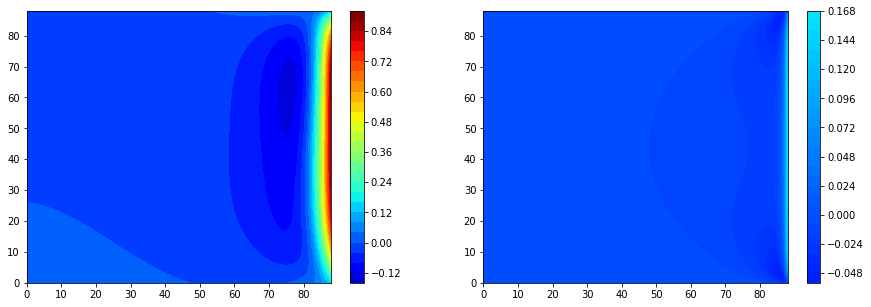

MovieWriter ffmpeg unavailable; using Pillow instead.


In [10]:
u_plot = u_out.data.cpu().numpy()
u_plot = np.reshape(u_plot, (89, 89))
usol = np.reshape(usol, (89, 89, 399))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# standardizing colorbar range
vmin = min(np.min(u_plot), np.min(usol))
vmax = max(np.max(u_plot), np.max(usol))

h = ax1.contourf(u_plot, levels=30, cmap='jet', vmin=vmin, vmax=vmax)
fig.colorbar(h, ax=ax1)

h = ax2.contourf(usol[:, :, 0], levels=30, cmap='jet', vmin=vmin, vmax=vmax)
fig.colorbar(h, ax=ax2)
plt.show()

def animate(i):
    ax1.clear()
    ax2.clear()
    u_out, v_out, f_out, g_out, h_out = PINN.function(x_test, y_test, 0.01*i*t_test)
    u_plot = u_out.data.cpu().numpy()
    u_plot = np.reshape(u_plot, (89, 89))
    cax = ax1.contourf(u_plot, levels=20, cmap='jet', vmin=vmin, vmax=vmax)
    cax = ax2.contourf(usol[:, :, i], levels=20, cmap='jet', vmin=vmin, vmax=vmax)
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$y$')
    ax2.set_xlabel(r'$x')
    ax2.set_ylabel(r'$y$')
    ax1.set_title(r'Predicted $u(x, \; y, \;t)$')
    ax2.set_title(r'Ground truth $u(x, \;y, \;t)$')

ani = animation.FuncAnimation(fig, animate, 50, interval=1, blit=False)
f = os.path.join(out_dir, 'u_field_ns_ic.gif')
ani.save(f)
plt.show()
    

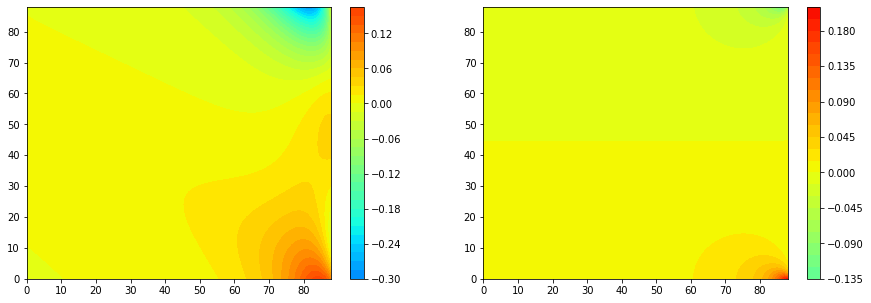

MovieWriter ffmpeg unavailable; using Pillow instead.


In [11]:
v_plot = v_out.data.cpu().numpy()
v_plot = np.reshape(v_plot, (89, 89))
vsol = np.reshape(vsol, (89, 89, 399))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# standardizing colorbar range
vmin = min(np.min(v_plot), np.min(vsol))
vmax = max(np.max(v_plot), np.max(vsol))

h = ax1.contourf(v_plot, levels=30, cmap='jet', vmin=vmin, vmax=vmax)
fig.colorbar(h, ax=ax1)

h = ax2.contourf(vsol[:, :, 0], levels=30, cmap='jet', vmin=vmin, vmax=vmax)
fig.colorbar(h, ax=ax2)
plt.show()

def animate(i):
    ax1.clear()
    ax2.clear()
    u_out, v_out, f_out, g_out, h_out = PINN.function(x_test, y_test, 0.01*i*t_test)
    v_plot = v_out.data.cpu().numpy()
    v_plot = np.reshape(v_plot, (89, 89))
    cax = ax1.contourf(v_plot, levels=20, cmap='jet', vmin=vmin, vmax=vmax)
    cax = ax2.contourf(vsol[:, :, i], levels=20, cmap='jet', vmin=vmin, vmax=vmax)
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$y$')
    ax2.set_xlabel(r'$x')
    ax2.set_ylabel(r'$y$')
    ax1.set_title(r'Predicted $v(x, \; y, \;t)$')
    ax2.set_title(r'Ground truth $v(x, \;y, \;t)$')

ani = animation.FuncAnimation(fig, animate, 50, interval=1, blit=False)
f = os.path.join(out_dir, 'v_field_ns_ic.gif')
ani.save(f)
plt.show()
    

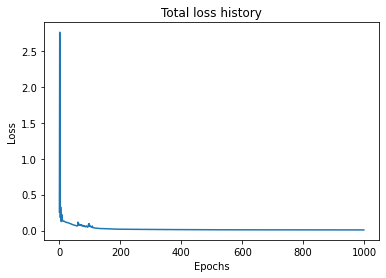

In [12]:
plt.plot(PINN.loss_history[:1000])
# plt.plot(PINN.loss_history)
plt.title("Total loss history")
plt.xlabel("Epochs")
plt.ylabel("Loss")
f = os.path.join(out_dir, 'total_loss.png')
plt.savefig(f, facecolor='white')

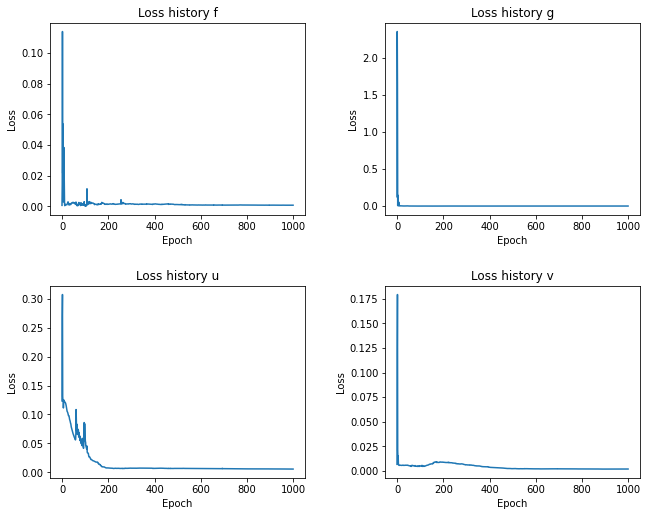

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.tight_layout(pad=5.0)
ax1.plot(PINN.loss_history_f[:1000])
ax1.set_title('Loss history f')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(PINN.loss_history_g[:1000])
ax2.set_title('Loss history g')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

ax3.plot(PINN.loss_history_u[:1000])
ax3.set_title('Loss history u')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')

ax4.plot(PINN.loss_history_v[:1000])
ax4.set_title('Loss history v')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')

f = os.path.join(out_dir, 'individual_loss.png')
plt.savefig(f, facecolor='white')

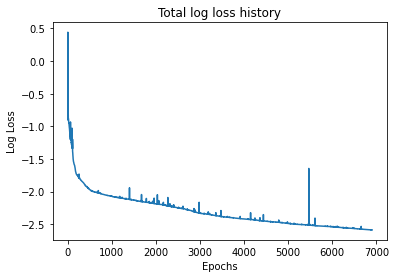

In [14]:
plt.plot(np.log10(PINN.loss_history))
# plt.plot(PINN.loss_history)
plt.title("Total log loss history")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
f = os.path.join(out_dir, 'total_log_loss.png')
plt.savefig(f, facecolor='white')

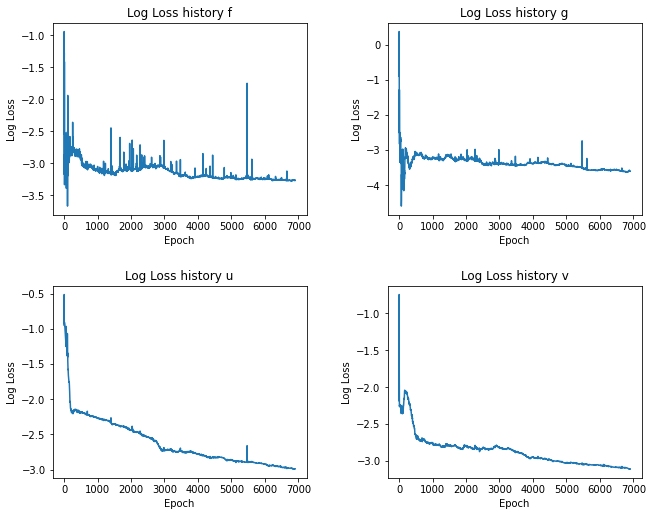

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.tight_layout(pad=5.0)
ax1.plot(np.log10(PINN.loss_history_f))
ax1.set_title('Log Loss history f')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Log Loss')

ax2.plot(np.log10(PINN.loss_history_g))
ax2.set_title('Log Loss history g')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Log Loss')

ax3.plot(np.log10(PINN.loss_history_u))
ax3.set_title('Log Loss history u')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Log Loss')

ax4.plot(np.log10(PINN.loss_history_v))
ax4.set_title('Log Loss history v')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Log Loss')
f = os.path.join(out_dir, 'individual_log_loss.png')
plt.savefig(f, facecolor='white')

In [16]:
# calculate relative L2 error and MSE
error_u, error_v = 0, 0
mse_u, mse_v = 0, 0
for i in range(T):
    u_out, v_out, f_out, g_out, h_out = PINN.function(x_test, y_test, 0.01*i*t_test)
    usol_i = usol[:, :, i].reshape(N, 1)
    vsol_i = vsol[:, :, i].reshape(N, 1)
    u_out = u_out.detach().cpu().numpy()
    v_out = v_out.detach().cpu().numpy()

    # L2 error calculations
    error_u += np.linalg.norm(usol_i-u_out, 2) / np.linalg.norm(usol_i, 2)
    error_v += np.linalg.norm(vsol_i-v_out, 2) / np.linalg.norm(vsol_i, 2)

    # MSE calculations
    mse_u += np.square(usol_i-u_out)/N
    mse_v += np.square(vsol_i-v_out)/N

error_u /= T
error_v /= T

print('Relative L2 Error:\n L2 Error u: %e \nL2 Error v: %e' % (error_u, error_v))
print('MSE:\nMSE u: %e\nMSE v: %e' % (mse_u, mse_v))

Error u: 6.230017e-01 
Error v: 7.988696e-01
